In [1]:
# %%
from kan import *
import numpy as np
import torch
import matplotlib.pyplot as plt
import pdb


In [2]:
# %%
import math
from torch.utils.data import Dataset

# f = lambda x: (x[:,[0]]**2 + x[:,[2]] + 3*torch.sin(x[:,[1]]))/(x[:,[0]] + 2*x[:,[1]] - x[:,[2]])
# sin(x) * cos(y) + exp(z/2) - x^2 * y
f = lambda x: torch.sin(x[:, [0]]) * torch.cos(x[:, [1]]) + torch.exp(x[:, [2]]/2) - x[:, [0]]**2 * x[:, [1]]
datasetall = create_dataset(f, n_var=3, train_num=20000, test_num=4000, seed=0, ranges=[[-5, 5], [-5, 5], [-5, 5]])
datasetoct0 = create_dataset(f, n_var=3, train_num=2500, test_num=500, seed=0, ranges=[[-5, 0], [-5, 0], [-5, 0]])


 ## build KAN architecture

 Training KAN

In [3]:
# %%
# setting bias_trainable=False, sp_trainable=False, sb_trainable=False is important.
# otherwise KAN will have random scaling and shift for samples in previous stages

model = KAN(width=[3,5,1], grid=10, k=3, sp_trainable=False, sb_trainable=False, noise_scale=0.1, device="cpu")
# model = KAN(width=[3,5,1], grid=5, k=3, noise_scale=0.1, device="cpu")
# model.train(datasetoct0, opt = 'Adam', steps=5000, update_grid=False, device="cuda", lr=0.02);
model.train(datasetoct0, opt="LBFGS", steps=80);

train loss: 6.44e-02 | test loss: 8.14e-02 | reg: 2.31e+01 : 100%|██| 80/80 [00:34<00:00,  2.30it/s]


In [4]:
f_pred = model(datasetoct0['test_input'].to('cpu')).to('cpu').detach().numpy()

In [5]:
f_true = datasetoct0['test_label'].to('cpu').detach().numpy()

In [6]:
# compute R^2 between prediction and true value
r2 = 1 - np.sum((f_pred - f_true)**2)/np.sum(f_true**2)
print(f"R^2: {r2}")

f_pred = model(datasetall['test_input'].to('cpu')).to('cpu').detach().numpy()
f_true = datasetall['test_label'].to('cpu').detach().numpy()
r2 = 1 - np.sum((f_pred - f_true)**2)/np.sum(f_true**2)
print(f"R^2 of total dataset: {r2}")

R^2: 0.9999931568754619
R^2 of total dataset: -0.032715797424316406


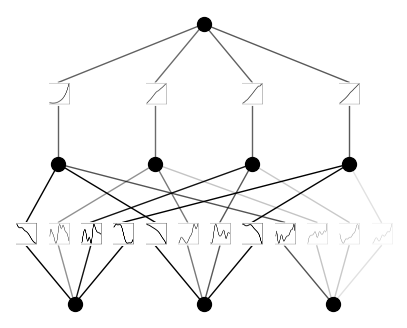

In [7]:
model = model.prune(threshold=0.1)
model(datasetoct0['train_input'].to("cpu"))
model.plot()

## retrain network using such model and see

In [8]:
# model.train(datasetoct0, opt = 'Adam', steps=5000, update_grid=False, device="cuda", lr=0.02);
model.train(datasetoct0, opt="LBFGS", steps=80);
f_pred = model(datasetoct0['test_input'].to('cpu')).to('cpu').detach().numpy()
f_true = datasetoct0['test_label'].to('cpu').detach().numpy()
r2 = 1 - np.sum((f_pred - f_true)**2)/np.sum(f_true**2)
print(f"R^2: {r2}")

f_pred = model(datasetall['test_input'].to('cpu')).to('cpu').detach().numpy()
f_true = datasetall['test_label'].to('cpu').detach().numpy()
r2 = 1 - np.sum((f_pred - f_true)**2)/np.sum(f_true**2)
print(f"R^2 of total dataset: {r2}")

train loss: 7.82e-02 | test loss: 8.80e-02 | reg: 1.67e+01 : 100%|██| 80/80 [00:30<00:00,  2.60it/s]

R^2: 0.9999919903002592
R^2 of total dataset: 0.1378278136253357


## looks good, as R^2 > 0.95. We will use the network for the next dataset

In [9]:
datasetoct1 = create_dataset(f, n_var=3, train_num=2500, test_num=500, seed=0, ranges=[[-5, 0], [-5, 0], [0, 5]])

### freeze/slow down/regularize/stop early network and determine nodes that is the opposite of pruning

In [10]:
# model.train(datasetoct1, opt = 'Adam', steps=5000, update_grid=False, device="cuda", lr=lr_half);

In [11]:
model.train(datasetoct1, opt="LBFGS", steps=int(80/2));
f_pred = model(datasetoct1['test_input'].to('cpu')).to('cpu').detach().numpy()
f_true = datasetoct1['test_label'].to('cpu').detach().numpy()
r2 = 1 - np.sum((f_pred - f_true)**2)/np.sum(f_true**2)
print(f"R^2: {r2}")

f_pred = model(datasetall['test_input'].to('cpu')).to('cpu').detach().numpy()
f_true = datasetall['test_label'].to('cpu').detach().numpy()
r2 = 1 - np.sum((f_pred - f_true)**2)/np.sum(f_true**2)
print(f"R^2 of total dataset: {r2}")

train loss: 8.38e-02 | test loss: 9.65e-02 | reg: 1.83e+01 : 100%|██| 40/40 [00:15<00:00,  2.63it/s]

R^2: 0.9999920646541796
R^2 of total dataset: 0.08780598640441895


Less catastrophic forgetting PROVIDED that the network is well pruned. Occam's Razor?

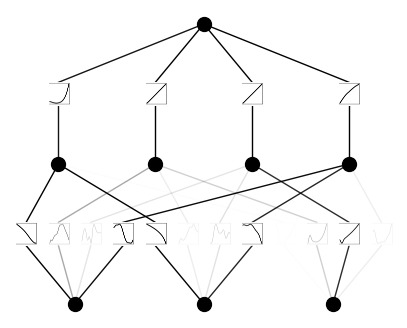

In [12]:
model = model.prune(threshold=0.1)
model(datasetoct1['train_input'].to("cpu"))
model.plot()

In [13]:
datasetoct2 = create_dataset(f, n_var=3, train_num=2500, test_num=500, seed=0, ranges=[[-5, 0], [0, 5], [-5, 0]])
model.train(datasetoct2, opt="LBFGS", steps=int(80/3));
f_pred = model(datasetoct2['test_input'].to('cpu')).to('cpu').detach().numpy()
f_true = datasetoct2['test_label'].to('cpu').detach().numpy()
r2 = 1 - np.sum((f_pred - f_true)**2)/np.sum(f_true**2)
print(f"R^2: {r2}")

f_pred = model(datasetall['test_input'].to('cpu')).to('cpu').detach().numpy()
f_true = datasetall['test_label'].to('cpu').detach().numpy()
r2 = 1 - np.sum((f_pred - f_true)**2)/np.sum(f_true**2)
print(f"R^2 of total dataset: {r2}")

train loss: 4.26e-01 | test loss: 4.04e-01 | reg: 1.92e+01 : 100%|██| 26/26 [00:09<00:00,  2.70it/s]

R^2: 0.9998500347865047
R^2 of total dataset: -2.429469585418701


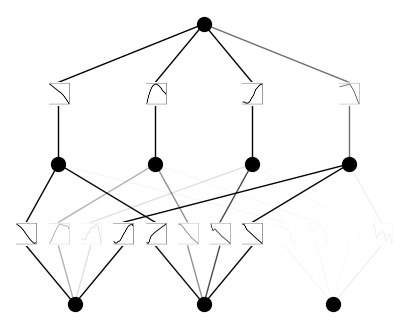

In [14]:
model = model.prune(threshold=0.1)
model(datasetoct2['train_input'].to("cpu"))
model.plot()

In [15]:
datasetoct3 = create_dataset(f, n_var=3, train_num=2500, test_num=500, seed=0, ranges=[[-5, 0], [0, 5], [0, 5]])
model.train(datasetoct3, opt="LBFGS", steps=int(80/4));
f_pred = model(datasetoct3['test_input'].to('cpu')).to('cpu').detach().numpy()
f_true = datasetoct3['test_label'].to('cpu').detach().numpy()
r2 = 1 - np.sum((f_pred - f_true)**2)/np.sum(f_true**2)
print(f"R^2: {r2}")

f_pred = model(datasetall['test_input'].to('cpu')).to('cpu').detach().numpy()
f_true = datasetall['test_label'].to('cpu').detach().numpy()
r2 = 1 - np.sum((f_pred - f_true)**2)/np.sum(f_true**2)
print(f"R^2 of total dataset: {r2}")

train loss: 4.44e-01 | test loss: 4.49e-01 | reg: 2.04e+01 : 100%|██| 20/20 [00:07<00:00,  2.60it/s]

R^2: 0.9997848986677127
R^2 of total dataset: -3.043355941772461


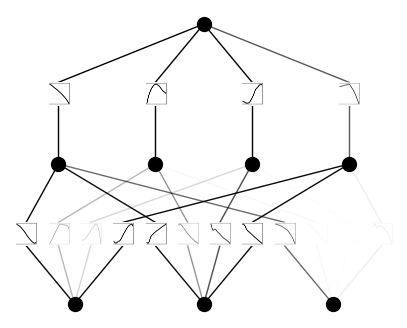

In [16]:
model = model.prune(threshold=0.1)
model(datasetoct3['train_input'].to("cpu"))
model.plot()

In [17]:
datasetoct4 = create_dataset(f, n_var=3, train_num=2500, test_num=500, seed=0, ranges=[[0, 5], [-5, 0], [-5, 0]])
model.train(datasetoct4, opt="LBFGS", steps=int(80/5));
f_pred = model(datasetoct4['test_input'].to('cpu')).to('cpu').detach().numpy()
f_true = datasetoct4['test_label'].to('cpu').detach().numpy()
r2 = 1 - np.sum((f_pred - f_true)**2)/np.sum(f_true**2)
print(f"R^2: {r2}")

f_pred = model(datasetall['test_input'].to('cpu')).to('cpu').detach().numpy()
f_true = datasetall['test_label'].to('cpu').detach().numpy()
r2 = 1 - np.sum((f_pred - f_true)**2)/np.sum(f_true**2)
print(f"R^2 of total dataset: {r2}")

train loss: 3.93e-01 | test loss: 4.16e-01 | reg: 1.68e+01 : 100%|██| 16/16 [00:06<00:00,  2.41it/s]

R^2: 0.9998272083030315
R^2 of total dataset: -0.3068668842315674


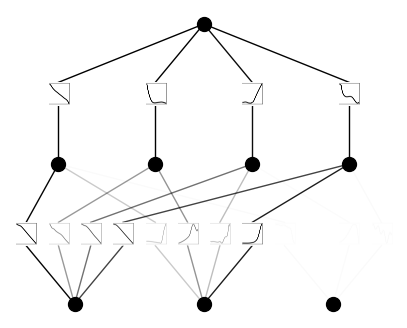

In [18]:
model = model.prune(threshold=0.1)
model(datasetoct4['train_input'].to("cpu"))
model.plot()

train loss: 4.05e-01 | test loss: 3.67e-01 | reg: 1.76e+01 : 100%|██| 13/13 [00:05<00:00,  2.48it/s]


R^2: 0.9998897911209497
R^2 of total dataset: -0.27749812602996826


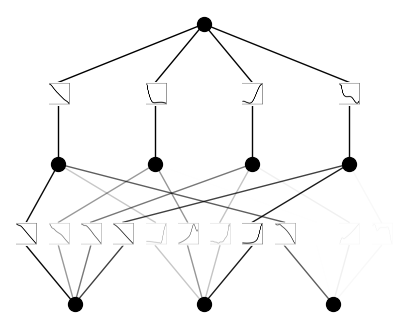

In [19]:
datasetoct5 = create_dataset(f, n_var=3, train_num=2500, test_num=500, seed=0, ranges=[[0, 5], [-5, 0], [0, 5]])
model.train(datasetoct5, opt="LBFGS", steps=int(80/6));
f_pred = model(datasetoct5['test_input'].to('cpu')).to('cpu').detach().numpy()
f_true = datasetoct5['test_label'].to('cpu').detach().numpy()
r2 = 1 - np.sum((f_pred - f_true)**2)/np.sum(f_true**2)
print(f"R^2: {r2}")

f_pred = model(datasetall['test_input'].to('cpu')).to('cpu').detach().numpy()
f_true = datasetall['test_label'].to('cpu').detach().numpy()
r2 = 1 - np.sum((f_pred - f_true)**2)/np.sum(f_true**2)
print(f"R^2 of total dataset: {r2}")

model = model.prune(threshold=0.1)
model(datasetoct5['train_input'].to("cpu"))
model.plot()

train loss: 1.26e+00 | test loss: 1.18e+00 | reg: 1.68e+01 : 100%|██| 11/11 [00:04<00:00,  2.54it/s]


R^2: 0.9984267080435529
R^2 of total dataset: 0.1288338303565979


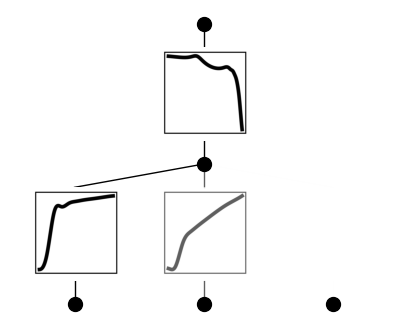

In [20]:
datasetoct6 = create_dataset(f, n_var=3, train_num=2500, test_num=500, seed=0, ranges=[[0, 5], [0, 5], [-5, 0]])
model.train(datasetoct6, opt="LBFGS", steps=int(80/7));
f_pred = model(datasetoct6['test_input'].to('cpu')).to('cpu').detach().numpy()
f_true = datasetoct6['test_label'].to('cpu').detach().numpy()
r2 = 1 - np.sum((f_pred - f_true)**2)/np.sum(f_true**2)
print(f"R^2: {r2}")

f_pred = model(datasetall['test_input'].to('cpu')).to('cpu').detach().numpy()
f_true = datasetall['test_label'].to('cpu').detach().numpy()
r2 = 1 - np.sum((f_pred - f_true)**2)/np.sum(f_true**2)
print(f"R^2 of total dataset: {r2}")

model = model.prune(threshold=0.1)
model(datasetoct6['train_input'].to("cpu"))
model.plot()

train loss: 2.70e+00 | test loss: 2.71e+00 | reg: 3.72e+00 : 100%|██| 10/10 [00:02<00:00,  4.89it/s]


R^2: 0.9900069534778595
R^2 of total dataset: 0.15127569437026978


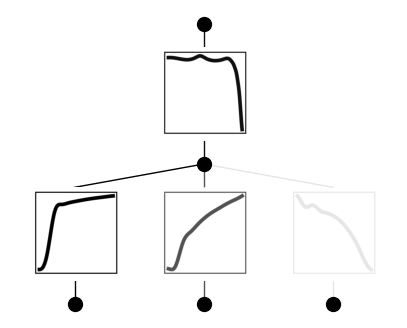

In [21]:
datasetoct7 = create_dataset(f, n_var=3, train_num=2500, test_num=500, seed=0, ranges=[[0, 5], [0, 5], [0, 5]])
model.train(datasetoct7, opt="LBFGS", steps=int(80/8));
f_pred = model(datasetoct7['test_input'].to('cpu')).to('cpu').detach().numpy()
f_true = datasetoct7['test_label'].to('cpu').detach().numpy()
r2 = 1 - np.sum((f_pred - f_true)**2)/np.sum(f_true**2)
print(f"R^2: {r2}")

f_pred = model(datasetall['test_input'].to('cpu')).to('cpu').detach().numpy()
f_true = datasetall['test_label'].to('cpu').detach().numpy()
r2 = 1 - np.sum((f_pred - f_true)**2)/np.sum(f_true**2)
print(f"R^2 of total dataset: {r2}")

model = model.prune(threshold=0.1)
model(datasetoct7['train_input'].to("cpu"))
model.plot()